# Exploratory Data Analysis

Let's import the necessary packages and also figure out where our data is:

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
DATASET_PATH = "../datasets/aclImdb"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"

## Load the data
Begin by loading the data. Content and labels are stored in a list of bytes:

In [4]:
from sklearn.datasets import load_files
reviews_train = load_files(TRAIN_PATH)

# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'list'>
length of text_train: 25000
text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


Note that there are some left over HTML strings. We will clean up our text and also remove stopwords and compare the postiive and negative classes.

In [5]:
def remove_stopwords(text, stopwords = stopwords.words('english')):
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

eng_stopwords = stopwords.words('english')
text_train = [remove_stopwords(str(doc.replace(b"<br />", b" "))[1:]) for doc in text_train]

pos_text = np.extract(y_train == 1, text_train)
neg_text = np.extract(y_train == 0, text_train)

## Word Cloud

Next we will evaluate the frequency of words between the two classes. We will visualize this by using a word cloud, removing excessively common words between both classes.

In [28]:
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.add('movie')
custom_stopwords.add('film')
custom_stopwords.add('character')
custom_stopwords.add('one')

Word clouds require the input to be one input string so we concatenate all our observations. In order to color the words uniformly, we set the ```color_func``` argument to return a single color string. NOTE: generating the word cloud requires a bit of time.

In [41]:
pos_words = ' '.join(pos_text)
neg_words = ' '.join(neg_text)

pos_wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10, 
                          background_color ='black', stopwords = custom_stopwords,
                          colormap = "Blues").generate(pos_words)

neg_wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10, 
                          background_color ='black', stopwords = custom_stopwords,
                          colormap = "Reds").generate(neg_words)

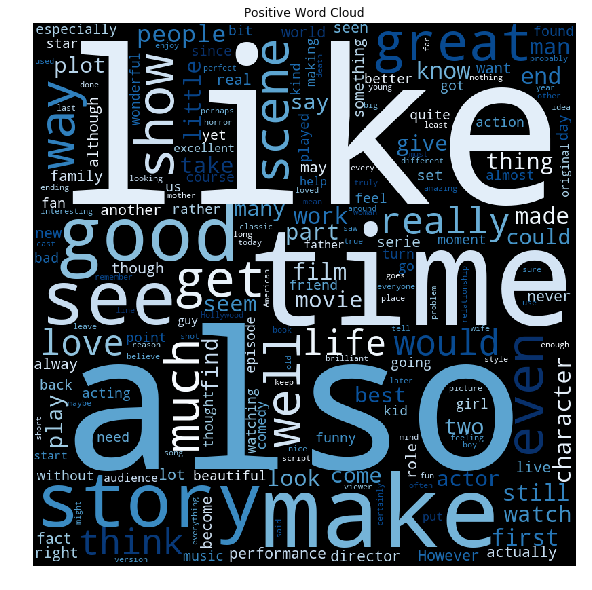

In [42]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(pos_wordcloud) 
plt.axis("off")
plt.title("Positive Word Cloud")
plt.tight_layout(pad = 0) 
plt.show() 

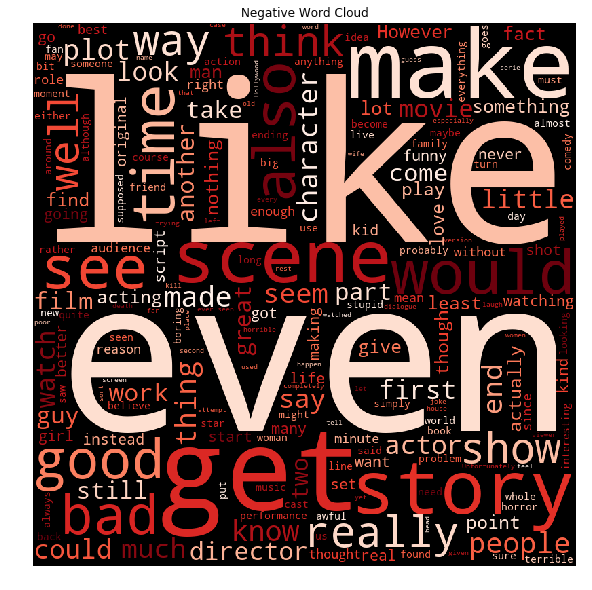

In [43]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(neg_wordcloud) 
plt.axis("off")
plt.title("Negative Word Cloud")
plt.tight_layout(pad = 0) 
plt.show()

While there are a few differences between the classes from this visual, there is significant overlap. For example, "good" is a very common word even in the negative word cloud. This suggests simply looking at individual words is not an effective means of differentiating the classes. We will evaluate bigrams to determine if the added context of the neighboring word provides better insights.

## Bigram distribution
We will compare the frequency of bigrams in the positive and negative reviews. First, we will clean the text by removing the punctuation and converting all the lower.

In [44]:
pos_string_list = [text.translate(str.maketrans('', '', string.punctuation)).lower() for text in pos_text]
neg_string_list = [text.translate(str.maketrans('', '', string.punctuation)).lower() for text in neg_text]

pos_bigrams = [nltk.bigrams(text.split()) for text in pos_string_list] # nltk.bigrams requires input to be a list
neg_bigrams = [nltk.bigrams(text.split()) for text in neg_string_list]

Next, we unwrap the bigram results for the documents in each of the classes and find the frequencies of bigrams. We format the output in a DataFrame to visualize.

In [45]:
pos_bigrams = [bigram for text in pos_bigrams for bigram in text]
neg_bigrams = [bigram for text in neg_bigrams for bigram in text]

pos_freq = nltk.FreqDist(pos_bigrams)
neg_freq = nltk.FreqDist(neg_bigrams)

In [47]:
pos_top25 = [(w1 + " " + w2, x) for ((w1,w2), x) in pos_freq.most_common(25)]
neg_top25 = [(w1 + " " + w2, x) for ((w1,w2), x) in neg_freq.most_common(25)]

In [48]:
pos_df = pd.DataFrame(pos_top25, columns =['bigram', 'frequency'])
neg_df = pd.DataFrame(neg_top25, columns =['bigram', 'frequency'])

Here, we see there is a lot more of a distinction between the classes. For example in positive reviews: "good movie", "great movie", "well done", "one best", "must see". In negative reviews: "bad movie", "low budget", "bad acting", "waste time". 

Interestingly, both negative and postive reviews seem to critique the "special effects". There is still overlap in these classes with "watch movie" and "see movie".

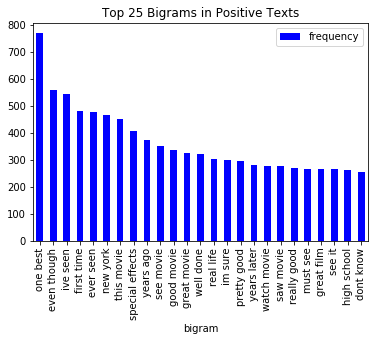

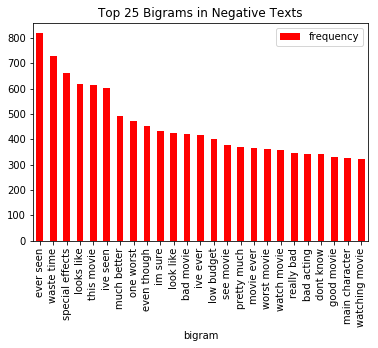

In [49]:
pos_df.plot.bar(x = 'bigram', y = 'frequency', color = 'blue',
                title = 'Top 25 Bigrams in Positive Texts')
neg_df.plot.bar(x = 'bigram', y = 'frequency', color = 'red',
                title = 'Top 25 Bigrams in Negative Texts')

In [58]:
pos_top50 = [(w1 + " " + w2, x) for ((w1,w2), x) in pos_freq.most_common(50)]
neg_top50 = [(w1 + " " + w2, x) for ((w1,w2), x) in neg_freq.most_common(50)]

pos_bigram_wc = WordCloud(width = 800, height = 800, min_font_size = 10, 
                          background_color ='black', stopwords = custom_stopwords,
                          colormap = "Blues").generate_from_frequencies(dict(pos_top50))

neg_bigram_wc = WordCloud(width = 800, height = 800, min_font_size = 10, 
                          background_color ='black', stopwords = custom_stopwords,
                          colormap = "Reds").generate_from_frequencies(dict(neg_top50))

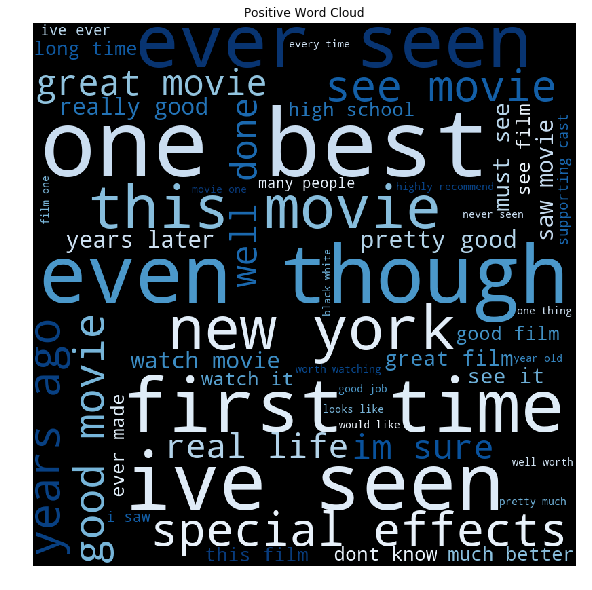

In [59]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(pos_bigram_wc) 
plt.axis("off")
plt.title("Positive Word Cloud")
plt.tight_layout(pad = 0) 
plt.show() 

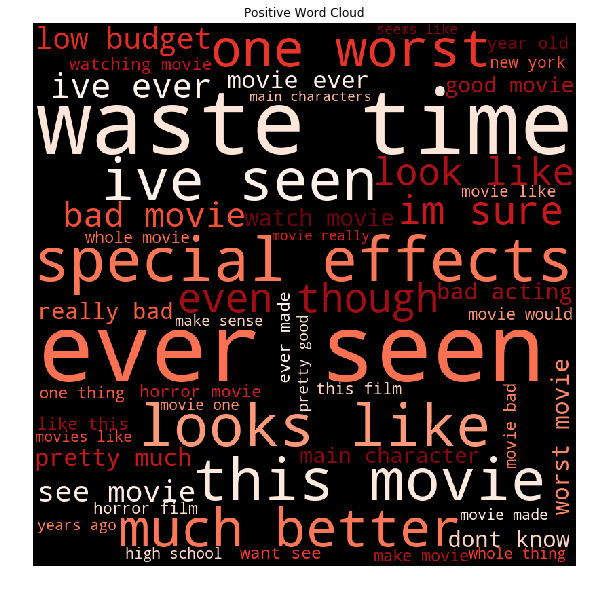

In [60]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(neg_bigram_wc) 
plt.axis("off")
plt.title("Positive Word Cloud")
plt.tight_layout(pad = 0) 
plt.show() 